In [12]:
import cv2
import glob
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import time
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline

### Confusion Matrix Helper Function

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Process and Store Images to a database

In [ ]:
FILE_PATH_PARASITIZED = "datasets\\Archived\\Parasitized\\"
FILE_PATH_UNINFECTED = "datasets\\Archived\\Uninfected\\"

In [ ]:
parasitized = glob.glob(FILE_PATH_PARASITIZED + "*.png")
uninfected = glob.glob(FILE_PATH_UNINFECTED + "*.png")

In [ ]:
x_list = []
y_list = []

for image in parasitized:
    img = cv2.imread(image)
    res = cv2.resize(img, dsize=(32,32))
    x_list.append(res)
    y_list.append(1)
    
for image in uninfected:
    img = cv2.imread(image)
    res = cv2.resize(img, dsize=(32,32))
    x_list.append(res)
    y_list.append(0)
    
x = np.array(x_list)
y = np.array(y_list)

x = x/255.
y = y.reshape((y.shape[0],1))

print("x.shape: %s" % str(x.shape))
print("y.shape: %s" % str(y.shape))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [ ]:
hf_train = h5py.File("train_malaria.h5", "w")
hf_train.create_dataset("train_set_x", data=X_train)
hf_train.create_dataset("train_set_y", data=y_train)
hf_train.close()

hf_test = h5py.File("test_malaria.h5", "w")
hf_test.create_dataset("test_set_x", data=X_test)
hf_test.create_dataset("test_set_y", data=y_test)
hf_test.close()

# Loading Data

In [3]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_malaria.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_malaria.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

In [4]:
X_train, Y_train, X_test, Y_test = load_dataset()

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test, Y_test, test_size=0.5)

print(X_train.shape)
print(Y_train.shape)

print(X_dev.shape)
print(Y_dev.shape)

print(X_test.shape)
print(Y_test.shape)

(18463, 32, 32, 3)
(18463, 1)
(4547, 32, 32, 3)
(4547, 1)
(4548, 32, 32, 3)
(4548, 1)


# Creating the Network

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(4,4), strides=1, padding="same", activation=tf.nn.relu, input_shape=(32,32,3)),
    tf.keras.layers.MaxPool2D(pool_size=(8,8), strides=8, padding="same"),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(2, 2), strides=1, padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=4, padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])  

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [7]:
model.fit(X_train, Y_train, epochs=100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
18463/18463 [==============================] - 7s 394us/sample - loss: 0.6414 - acc: 0.6470
Epoch 2/100
18463/18463 [==============================] - 4s 210us/sample - loss: 0.5041 - acc: 0.7733
Epoch 3/100
18463/18463 [==============================] - 4s 199us/sample - loss: 0.3574 - acc: 0.8511
Epoch 4/100
18463/18463 [==============================] - 3s 181us/sample - loss: 0.2212 - acc: 0.9140
Epoch 5/100
18463/18463 [==============================] - 4s 212us/sample - loss: 0.1613 - acc: 0.9452
Epoch 6/100
18463/18463 [==============================] - 4s 216us/sample - loss: 0.1530 - acc: 0.9501
Epoch 7/100
18463/18463 [==============================] - 4s 212us/sample - loss: 0.1467 - acc: 0.9524
Epoch 8/100
18463/18463 [==============================] - 4s 209us/sample - loss: 0.1429 - acc: 0.9535
Epoch 9/100
18463/18463 [==============================] - 4s 209us/sample - loss: 0.1403 - acc: 0.9546
Epoch 10/100
184

18463/18463 [==============================] - 4s 196us/sample - loss: 0.1026 - acc: 0.9649
Epoch 77/100
18463/18463 [==============================] - 3s 177us/sample - loss: 0.1015 - acc: 0.9650
Epoch 78/100
18463/18463 [==============================] - 4s 193us/sample - loss: 0.1032 - acc: 0.9654
Epoch 79/100
18463/18463 [==============================] - 3s 173us/sample - loss: 0.1024 - acc: 0.9647
Epoch 80/100
18463/18463 [==============================] - 3s 164us/sample - loss: 0.1007 - acc: 0.9651
Epoch 81/100
18463/18463 [==============================] - 3s 168us/sample - loss: 0.0996 - acc: 0.9663
Epoch 82/100
18463/18463 [==============================] - 3s 174us/sample - loss: 0.1009 - acc: 0.9648
Epoch 83/100
18463/18463 [==============================] - 4s 196us/sample - loss: 0.1004 - acc: 0.9652
Epoch 84/100
18463/18463 [==============================] - 4s 202us/sample - loss: 0.0994 - acc: 0.9656
Epoch 85/100
18463/18463 [==============================] - 3s 172us

In [8]:
dev_loss, dev_acc = model.evaluate(X_dev, Y_dev)

print('Dev set accuracy:', dev_acc)

4547/4547 [==============================] - 1s 115us/sample - loss: 0.1350 - acc: 0.9558
Dev set accuracy: 0.95579505


In [9]:
test_loss, test_acc = model.evaluate(X_test, Y_test)

print('Test set accuracy:', test_acc)

4548/4548 [==============================] - 0s 62us/sample - loss: 0.1310 - acc: 0.9556
Test set accuracy: 0.9555849


[False]


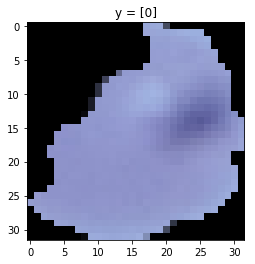

In [10]:
index = 999
predictions = model.predict(X_test) > 0.5
print(predictions[index])
plt.title("y = %s" % Y_test[index])
plt.imshow(X_test[index])

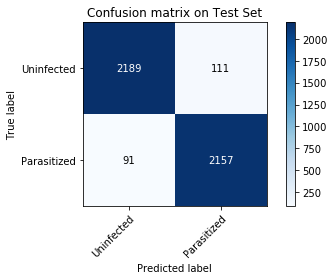

In [13]:
plot_confusion_matrix(Y_test, predictions, classes=["Uninfected","Parasitized"], title='Confusion matrix on Test Set')